In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Layer
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Create synthetic time series data (a sine wave)
data = np.sin(np.linspace(0, 100, 500))  # 500 time steps
data = data.reshape(-1, 1)

# Normalize the data to the range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Create sequences: use 20 time steps to predict the next value
seq_length = 20
X, y = [], []
for i in range(seq_length, len(data_scaled)):
    X.append(data_scaled[i-seq_length:i, 0])
    y.append(data_scaled[i, 0])
X = np.array(X)
y = np.array(y)
# Reshape X to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
print(X.shape, y.shape)

(480, 20, 1) (480,)


In [3]:
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create trainable weights for computing attention scores
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], input_shape[-1]), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[-1],), initializer="zeros")
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        # Compute alignment scores using tanh activation
        score = tf.tanh(tf.matmul(inputs, self.W) + self.b)
        # Normalize scores to get attention weights
        attention_weights = tf.nn.softmax(score, axis=1)
        # Compute the context vector as a weighted sum of inputs
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

In [4]:
# Define the input layer with shape (seq_length, 1)
input_seq = Input(shape=(seq_length, 1))
# Add an LSTM layer that outputs the full sequence
lstm_out = LSTM(50, return_sequences=True)(input_seq)
# Apply the custom attention layer
context_vector, attention_weights = AttentionLayer()(lstm_out)
# Add a final Dense layer for regression (linear activation)
output = Dense(1, activation='linear')(context_vector)
# Create the model
model = Model(inputs=input_seq, outputs=output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 20, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 20, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer                 │ [(None, 50), (None,    │         2,550 │
│ (AttentionLayer)                │ 20, 50)]               │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,001 (50.79 KB)

 Trainable params: 13,001 (50.79 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
model.compile(optimizer='adam', loss='mse')
history = model.fit(X, y, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2571 - val_loss: 0.2112
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2070 - val_loss: 0.1867
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1767 - val_loss: 0.1599
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1431 - val_loss: 0.1085
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0583 - val_loss: 0.0036
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0122 - val_loss: 0.0031
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0029
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0010 - val_loss: 7.2323e-04
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.1986e-04 - val_loss: 3.7155e-04
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.7093e-04 - val_loss: 2.4951e-04
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - 

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2505e-05 
Test Loss: 2.2505280867335387e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


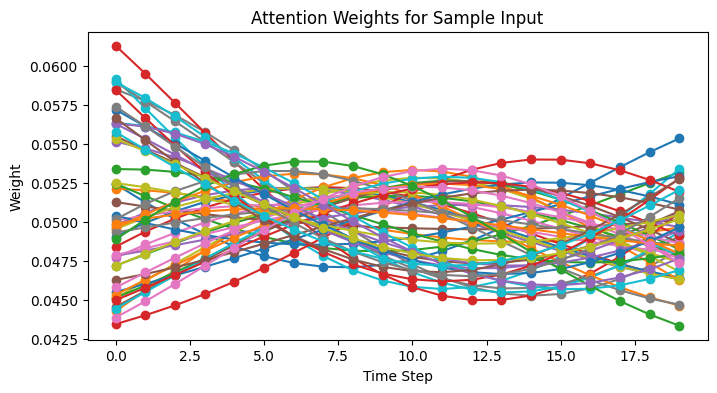

In [6]:
loss = model.evaluate(X, y)
print("Test Loss:", loss)

# Create a model to output the attention weights
attention_model = Model(inputs=model.input, outputs=attention_weights)
# Select a sample input from the dataset
sample_index = 0  # You can change this to another index
sample_input = X[sample_index:sample_index+1]
att_weights = attention_model.predict(sample_input)

# Visualize the attention weights for the sample input
plt.figure(figsize=(8, 4))
plt.plot(att_weights[0], marker='o')
plt.title("Attention Weights for Sample Input")
plt.xlabel("Time Step")
plt.ylabel("Weight")
plt.show()